In [3]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [4]:
import logging
logging.basicConfig(level=logging.INFO)

import numpy
from numpy.testing import assert_array_almost_equal

from atomlib import make
from atomlib.visualize import show_atoms_mpl_2d, show_atoms_mpl_3d

# Coordinate systems

For convenience, `atomlib` allows you to operate on atoms in a variety of coordinate systems.
When atom boundaries are known (as in `AtomCell`), raw coordinates are always stored in a known coordinate system,
and these coordinates can be accessed and modified transparently from any other coordinate system. Here are some examples:

Below, we can see that atoms are stored in the 'local' coordinate system, which refers to Cartesian coordinates after any transformation:

In [5]:
ceo2_prim = make.fluorite('CeO2', 5.47, cell='prim')
ceo2_prim

Cell size:  [3.86787409 3.86787409 3.86787409]
Cell angle: [1.04719755 1.04719755 1.04719755]
# Cells: [1 1 1]
Frame: local
Atoms, shape: (3, 5)
┌────────┬────────┬────────┬──────┬────────┐
│ x      ┆ y      ┆ z      ┆ elem ┆ symbol │
│ ---    ┆ ---    ┆ ---    ┆ ---  ┆ ---    │
│ f64    ┆ f64    ┆ f64    ┆ i8   ┆ str    │
╞════════╪════════╪════════╪══════╪════════╡
│ 0.0    ┆ 0.0    ┆ 0.0    ┆ 58   ┆ Ce     │
│ 1.3675 ┆ 1.3675 ┆ 1.3675 ┆ 8    ┆ O      │
│ 4.1025 ┆ 4.1025 ┆ 4.1025 ┆ 8    ┆ O      │
└────────┴────────┴────────┴──────┴────────┘

Now look at the same coordinates, but in cell fractional coordinates:

In [6]:
assert_array_almost_equal(ceo2_prim.coords(frame='cell_frac'), [
    [0.,   0.,   0.    ],
    [0.25, 0.25, 0.25  ],
    [0.75, 0.75, 0.75  ],
])

Or in cell realspace coordinates:

In [7]:
assert_array_almost_equal(ceo2_prim.coords(frame='cell'), [
    [0.,     0.,     0.    ],
    [0.9970, 0.9970, 0.9970],
    [2.9009, 2.9909, 2.9909],
], decimal=0.3)

For supercells with translational periodicity, the `cell_box` coordinate space can be used to refer to supercell-fractional coordinates, or the `cell_frac` can be used to refer to unit cell fractional coordinates:

In [11]:
ceo2_repeated = ceo2_prim.repeat((2, 3, 4))

print(f"Maximum `cell_frac` size:")
print(numpy.max(ceo2_repeated.coords(frame='cell_frac'), axis=0))

print(f"Maximum `cell_box` size:")
print(numpy.max(ceo2_repeated.coords(frame='cell_box'), axis=0))

Maximum `cell_frac` size:
[1.75 2.75 3.75]
Maximum `cell_box` size:
[0.875      0.91666667 0.9375    ]


Here's an illustration of the different coordinate systems available:

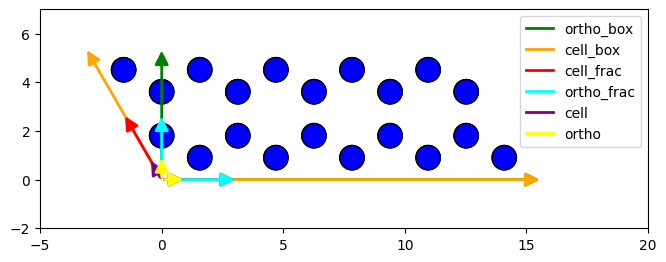

In [8]:
from matplotlib.patches import FancyArrowPatch

def draw_basis(ax, atoms, frame, color='black', **kwargs):
    transform = atoms.get_transform('local', frame)

    pts = transform.transform(
        numpy.concatenate([numpy.array([[0., 0., 0.]]), numpy.eye(3)])
    )[:3, :2]

    ax.plot([], [], linewidth=2.0, color=color, label=frame)  # for legend
    kwargs = {**dict(arrowstyle='-|>', color=color, linewidth=2.0, mutation_scale=20.), **kwargs}
    for i in range(2):
        ax.add_artist(FancyArrowPatch(pts[0], pts[i+1], **kwargs))


aln = make.wurtzite('AlN', 3.13, 5.02).repeat((5, 2, 1))

fig = show_atoms_mpl_2d(aln, zone=[0, 0, -1])
ax = fig.axes[0]

draw_basis(ax, aln, 'ortho_box', 'green')
draw_basis(ax, aln, 'cell_box', 'orange')
draw_basis(ax, aln, 'cell_frac', 'red')
draw_basis(ax, aln, 'ortho_frac', 'cyan')
draw_basis(ax, aln, 'cell', 'purple')
draw_basis(ax, aln, 'ortho', 'yellow')

ax.set_xlim(-5, 20)
ax.set_ylim(-2, 7)

ax.legend()

The `ortho` coordinate system is the same as `linear` and `local` in the above case, because no transformations have been applied to the crystal cell.

When transformations are present, then:
 - `ortho` remains fixed at the origin of the crystal, with the x-axis aligned along `a` and the y-axis in the `ab` plane.
 - `linear` remains fixed at the origin of the crystal, but with axes aligned to coordinates after any rotations have been applied.
 - `local` contains Cartesian coordinates after all transformations

## Using coordinate systems

Most functions which accept or filter on coordinates accept a `frame` parameter as well. Some examples:

In [9]:
import polars

print("Atoms in bottom half of unit cell:")
print(aln.filter(polars.col('z') <= 0.5, frame='cell_frac'))

print("Add partial occupancy to one atom, in frame cell_frac")
print(aln.with_occupancy(polars.when(
        aln.pos(4.3333, 1.6666, 0., tol=0.01)
    ).then(0.5).otherwise(1.0),
    frame='cell_frac'
))

Atoms in bottom half of unit cell:
Cell size:  [3.13 3.13 5.02]
Cell angle: [1.57079633 1.57079633 2.0943951 ]
# Cells: [5 2 1]
Frame: cell
Atoms, shape: (30, 5)
┌───────────┬──────────┬──────────┬──────┬────────┐
│ x         ┆ y        ┆ z        ┆ elem ┆ symbol │
│ ---       ┆ ---      ┆ ---      ┆ ---  ┆ ---    │
│ f64       ┆ f64      ┆ f64      ┆ i8   ┆ str    │
╞═══════════╪══════════╪══════════╪══════╪════════╡
│ 2.086667  ┆ 1.043333 ┆ 2.51     ┆ 13   ┆ Al     │
│ 1.043333  ┆ 2.086667 ┆ 0.0      ┆ 13   ┆ Al     │
│ 1.043333  ┆ 2.086667 ┆ 1.905525 ┆ 7    ┆ N      │
│ 5.216667  ┆ 1.043333 ┆ 2.51     ┆ 13   ┆ Al     │
│ …         ┆ …        ┆ …        ┆ …    ┆ …      │
│ 10.433333 ┆ 5.216667 ┆ 1.905525 ┆ 7    ┆ N      │
│ 14.606667 ┆ 4.173333 ┆ 2.51     ┆ 13   ┆ Al     │
│ 13.563333 ┆ 5.216667 ┆ 0.0      ┆ 13   ┆ Al     │
│ 13.563333 ┆ 5.216667 ┆ 1.905525 ┆ 7    ┆ N      │
└───────────┴──────────┴──────────┴──────┴────────┘
Add partial occupancy to one atom, in frame cell_frac
Cell

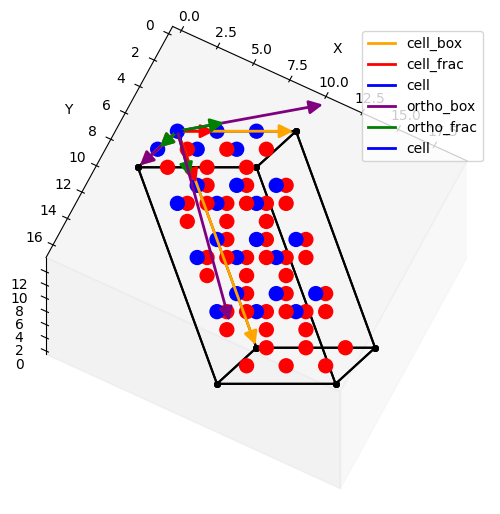

In [45]:
from matplotlib.patches import FancyArrowPatch
from mpl_toolkits.mplot3d import proj3d


class Arrow3D(FancyArrowPatch):
    def __init__(self, xs, ys, zs, *args, **kwargs):
        super().__init__((0,0), (0,0), *args, **kwargs)
        self._verts3d = xs, ys, zs

    def do_3d_projection(self, renderer=None):
        xs3d, ys3d, zs3d = self._verts3d
        xs, ys, zs = proj3d.proj_transform(xs3d, ys3d, zs3d, self.axes.M)
        self.set_positions((xs[0],ys[0]),(xs[1],ys[1]))

        return numpy.min(zs)


def draw_basis(ax, atoms, frame, color='black', **kwargs):
    transform = atoms.get_transform('local', frame)

    pts = transform.transform(
        numpy.concatenate([numpy.array([[0., 0., 0.]]), numpy.eye(3)])
    )

    # for legened
    ax.plot([], [], [], linewidth=2.0, color=color, label=frame)
    kwargs = {**dict(arrowstyle='-|>', color=color, linewidth=2.0, mutation_scale=20.), **kwargs}
    for i in range(3):
        ax.add_artist(Arrow3D(*numpy.transpose([pts[0], pts[i+1]]), **kwargs))



fig = show_atoms_mpl_3d(ceo2_repeated, zone=[1, 2, 5]);
ax = fig.axes[0]

draw_basis(ax, ceo2_repeated, 'cell_box', 'orange')
draw_basis(ax, ceo2_repeated, 'cell_frac', 'red')
draw_basis(ax, ceo2_repeated, 'cell', 'blue', mutation_scale=5.)
draw_basis(ax, ceo2_repeated, 'ortho_box', 'purple')
draw_basis(ax, ceo2_repeated, 'ortho_frac', 'green')
draw_basis(ax, ceo2_repeated, 'cell', 'blue', mutation_scale=5.)
ax.legend()

